In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def loadCleanData(fname):
    df = pd.read_csv(fname)
    
    # regularize capitalization and remove leading space in column headings
    fix_cols = {s : s.lower().strip() for s in df.columns.to_list()}
    df.rename(columns = fix_cols, inplace=True)
    
    # convert pixels from strings to lists of integers
    df['pixels'] = df['pixels'].apply(lambda x: [int(i) for i in x.split()])
    
    df.drop('usage', axis=1, inplace=True)
    
    return df

In [5]:
df = loadCleanData('../data/icml_face_data.csv')
df.head()

,emotion,pixels
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [9]:
classes = ['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear']

In [10]:
def showExample(df, index):
    img = np.array(df.iloc[index]['pixels']).reshape(48, 48)
    plt.imshow(img, cmap='gray')
    plt.title(classes[df.iloc[index]['emotion']])
    plt.show()
    

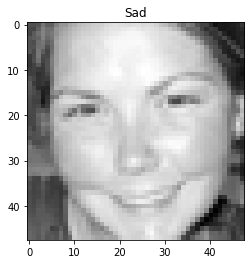

In [11]:
showExample(df, 8)

In [14]:
# Majority rule
def makeClasses(votes):
  probs = []
  for row in range(votes.shape[0]):
    # put any contempt votes to disgust
    votes[row][5] += votes[row][7]
    y = np.argmax(votes[row][:7])
    probs.append(y)

  return np.array(probs)

In [15]:
df_labels = pd.read_csv('https://raw.githubusercontent.com/microsoft/FERPlus/master/fer2013new.csv')
df_labels = df_labels[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']]
fer2013_new = pd.concat([df, df_labels], axis=1)
fer2013_new = fer2013_new[fer2013_new['NF'] < 10]


In [16]:
y = fer2013_new[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']].values
fer2013_new['emotion'] = makeClasses(y)
fer2013_new.head(10)

,emotion,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",4,0,0,1,3,2,0,0,0,0
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",6,0,1,1,0,0,0,0,2,0
2,0,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",5,0,0,3,1,0,0,0,1,0
3,0,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4,0,0,4,1,0,0,0,1,0
4,0,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",9,0,0,1,0,0,0,0,0,0
5,0,"[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151, ...",6,0,0,1,0,0,1,1,1,0
6,3,"[20, 17, 19, 21, 25, 38, 42, 42, 46, 54, 56, 6...",2,0,0,8,0,0,0,0,0,0
7,1,"[77, 78, 79, 79, 78, 75, 60, 55, 47, 48, 58, 7...",0,10,0,0,0,0,0,0,0,0
8,1,"[85, 84, 90, 121, 101, 102, 133, 153, 153, 169...",0,10,0,0,0,0,0,0,0,0
9,2,"[255, 254, 255, 254, 254, 179, 122, 107, 95, 1...",0,0,6,0,0,0,4,0,0,0


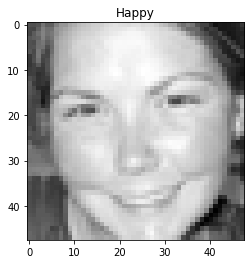

In [18]:
showExample(fer2013_new, 8)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [27]:
x_train, x_test, y_train, y_test = train_test_split(fer2013_new['pixels'],
                                                    fer2013_new['emotion'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=fer2013_new['emotion'])

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((28568,), (7143,), (28568,), (7143,))

In [28]:
clf = DummyClassifier()
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
print(f'Total baseline = {round(score * 100, 2)} %')

Total baseline = 22.95 %


C:\Users\A\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [29]:
# transform lists of integers into numpy arrays, and normalize the values
x_train = np.vstack(x_train) / 255
x_test = np.vstack(x_test) / 255

# reshape arrays into (m, h, w, c). As they are square, we can get the height
# and width values as a square root of the length the original 1-d array.
n = int(np.sqrt(x_train.shape[1]))
x_train = x_train.reshape(x_train.shape[0], n, n, 1)
x_test = x_test.reshape(x_test.shape[0], n, n, 1)

# Convert the pandas series of target classes to numpy array
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

x_train.shape, y_train.shape

((28568, 48, 48, 1), (28568,))

In [30]:
model = Sequential([Conv2D(64, (3, 3), input_shape=x_train.shape[1:], activation='relu'),
                    MaxPool2D((2, 2)),
                    Conv2D(128, (3, 3), activation='relu'),
                    MaxPool2D((2, 2)),
                    Conv2D(256, (3, 3), activation='relu'),
                    MaxPool2D((2, 2)),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(7, activation='softmax')])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)             

In [31]:
stop = EarlyStopping(monitor='val_acc', patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint('model.h5', monitor='val_acc', save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

history = model.fit(x_train,
          y_train,
          validation_data=(x_test, y_test),
          epochs=100,
          batch_size=128,
          callbacks=[stop, checkpoint, reduce_lr])

Train on 28568 samples, validate on 7143 samples
Epoch 1/100
28568/28568 [==============================] - 377s 13ms/sample - loss: 1.5303 - acc: 0.4076 - val_loss: 1.5053 - val_acc: 0.4627
Epoch 2/100
28568/28568 [==============================] - 367s 13ms/sample - loss: 1.1714 - acc: 0.5880 - val_loss: 1.0483 - val_acc: 0.6310
Epoch 3/100
28568/28568 [==============================] - 349s 12ms/sample - loss: 0.9677 - acc: 0.6559 - val_loss: 0.9285 - val_acc: 0.6667
Epoch 4/100
28568/28568 [==============================] - 350s 12ms/sample - loss: 0.8561 - acc: 0.6939 - val_loss: 0.8676 - val_acc: 0.6858
Epoch 5/100
28568/28568 [==============================] - 359s 13ms/sample - loss: 0.7657 - acc: 0.7248 - val_loss: 0.8056 - val_acc: 0.7091
Epoch 6/100
28568/28568 [==============================] - 372s 13ms/sample - loss: 0.6898 - acc: 0.7524 - val_loss: 0.8485 - val_acc: 0.6956
Epoch 7/100
28568/28568 [==============================] - 352s 12ms/sample - loss: 0.6162 - acc: 0

In [32]:
score = model.evaluate(x_test, y_test, verbose=0)[1]
print(f'Accuracy = {round(score * 100, 2)} %')

Accuracy = 73.6 %


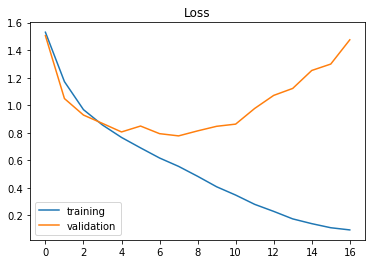

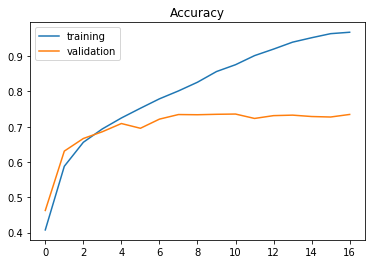

In [33]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

In [34]:
def tryRandomExample():
    index = np.random.randint(0, x_test.shape[0])
    img = x_test[index]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    best = np.argmax(pred[0])
    
    print(classes[best] == classes[y_test[index]])
    print(f'Predicted label: {classes[best]}\nConfidence: {round(pred[0][best] * 100, 2)} %')
    print(f'Actual label: {classes[y_test[index]]}')
    
    plt.imshow(np.squeeze(img[0], axis=-1), cmap='gray')
    plt.show()
    
    plt.bar(classes, pred[0])
    plt.show()
    
    

False
Predicted label: Neutral
Confidence: 82.65 %
Actual label: Angry


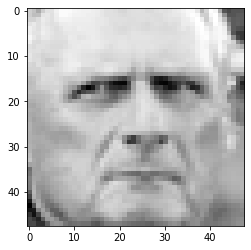

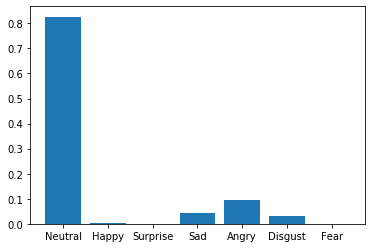

In [47]:
tryRandomExample()

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

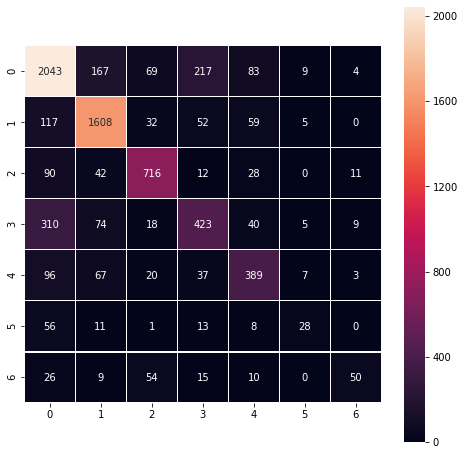

In [40]:
preds = model.predict(x_test)
y_pred = [np.argmax(pred) for pred in preds]
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
ax = sns.heatmap(cm, annot=True, fmt='d', linewidths=.2, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);


In [41]:
model.save('../models/conv_model.h5')

In [42]:
from tensorflow.keras.models import load_model

model = load_model('../models/conv_model.h5')


In [43]:
import cv2
import dlib
from imutils import resize, face_utils

detector = dlib.get_frontal_face_detector()
classes = ['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear']


def predictEmotion(image):
  image = cv2.imread(image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 1)

  for rect in rects:
    img = gray[rect.top(): rect.bottom() + 1, rect.left(): rect.right() + 1]
    img = resize(img, width=48, height=48) / 255
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)

    probs = model.predict(img)
    predict = np.argmax(probs[0])
    prob = probs[0][predict]

    caption = f'{classes[predict]} {str(round(prob * 100))} %'
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    fontScale = min(w, h) / 200
    thickness = min(w, h) // 75
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), thickness) 
    cv2.putText(image, caption,(x - 10, y - 10),
		        cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 0, 255), thickness)

  plt.figure(figsize=(10,15))
  plt.imshow(image)
  plt.xlabel(f'{probs}')
  return image

ModuleNotFoundError: No module named 'dlib'